In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML

set constant

In [21]:

CHENNELS = 3,
EPOCHS = 5

In [25]:
import tensorflow as tf

# Set your desired image size
IMAGE_SIZE = 256  
BATCH_SIZE = 32  
CHENNELS = 3
EPOCHS = 5

image_directory = '/kaggle/input/tomato-disease-classification-1'


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)




Found 5452 files belonging to 4 classes.


In [26]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

Image shape

In [27]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
(32,)
[3 1 0 1 1 3 1 3 3 0 0 1 2 1 0 3 3 2 3 2 3 3 2 3 1 0 2 3 1 1 2 0]


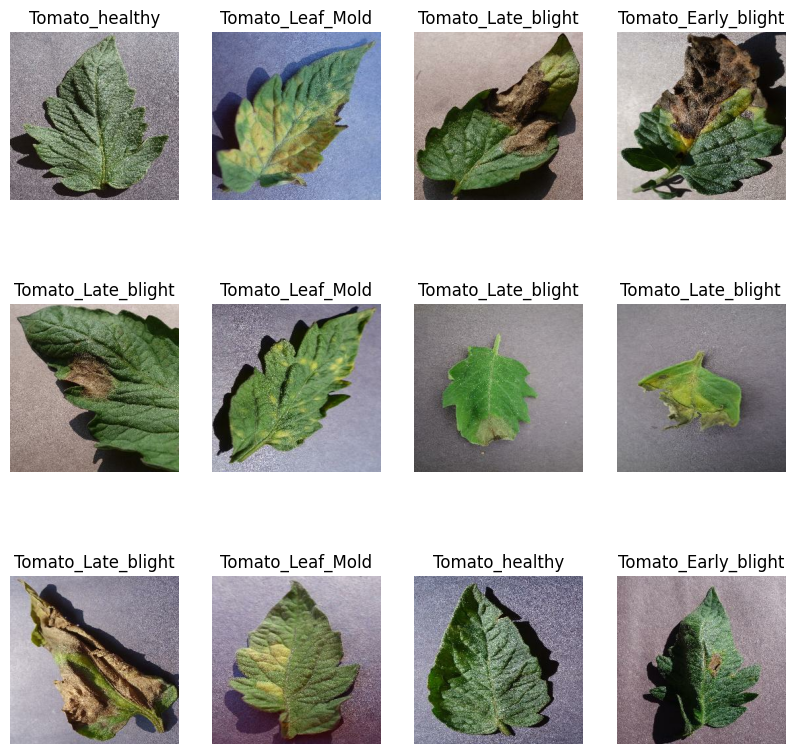

In [28]:
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

Spliting datast

In [29]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [30]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

136

In [32]:
len(test_ds)

18

In [33]:
len(val_ds)

17

# Prefetch Data

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building Model

In [35]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 256)
])

Data Augmentation

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Applying data augmentation on train_ds

In [37]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Archtiecture

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHENNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='sigmoid')
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 60, 60, 128)        

In [40]:
model.compile(optimizer='adam',
             loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics= ['accuracy']
             
             )

In [41]:
%%time
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
136/136 [==============================] - 68s 297ms/step - loss: 1.3936 - accuracy: 0.5734 - val_loss: 0.9966 - val_accuracy: 0.6875
Epoch 2/50
136/136 [==============================] - 36s 265ms/step - loss: 0.7423 - accuracy: 0.7068 - val_loss: 0.6504 - val_accuracy: 0.7610
Epoch 3/50
136/136 [==============================] - 36s 266ms/step - loss: 0.5783 - accuracy: 0.7717 - val_loss: 0.7735 - val_accuracy: 0.6967
Epoch 4/50
136/136 [==============================] - 36s 266ms/step - loss: 0.6062 - accuracy: 0.7652 - val_loss: 0.8608 - val_accuracy: 0.6397
Epoch 5/50
136/136 [==============================] - 36s 266ms/step - loss: 0.5192 - accuracy: 0.8089 - val_loss: 0.6489 - val_accuracy: 0.8327
Epoch 6/50
136/136 [==============================] - 37s 268ms/step - loss: 0.5079 - accuracy: 0.8209 - val_loss: 0.5508 - val_accuracy: 0.8346
Epoch 7/50
136/136 [==============================] - 37s 269ms/step - loss: 0.4488 - accuracy: 0.8340 - val_loss: 0.5731 - val_ac

In [42]:
model.evaluate(test_ds)

18/18 [==============================] - 7s 25ms/step - loss: 0.1007 - accuracy: 0.9688


[0.10068968683481216, 0.96875]

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 136}

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

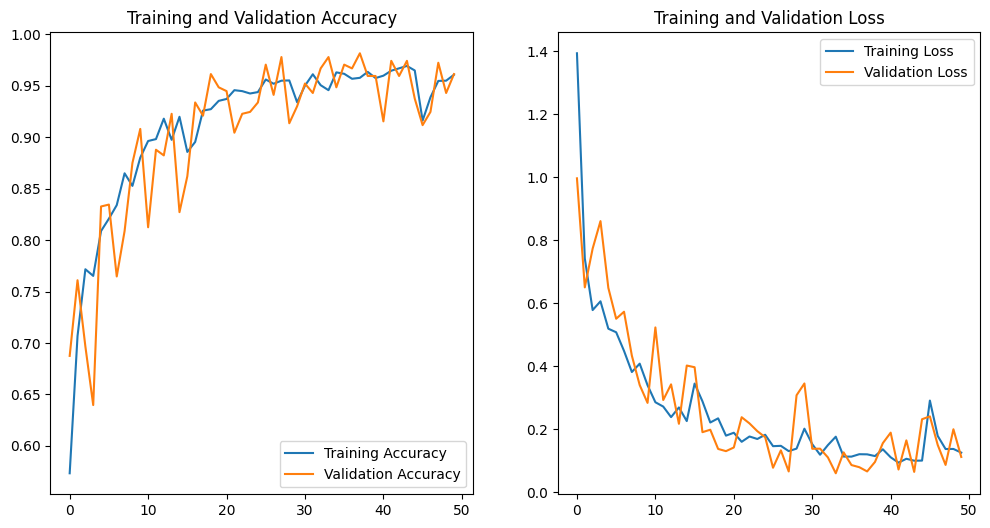

In [46]:
EPOCHS = len(acc)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Run Prediction on a sample image

first image to predict
actual lable: Tomato_Late_blight
1/1 [==============================] - 0s 30ms/step
prediction label:  Tomato_Late_blight


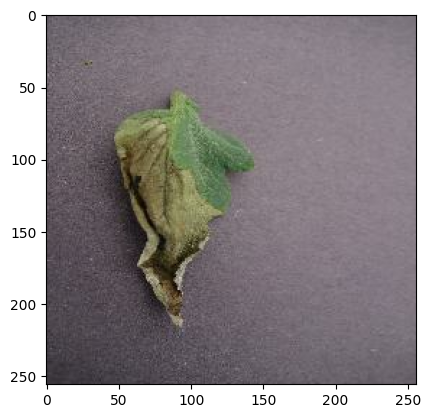

In [53]:
for image_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('actual lable:' , class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('prediction label: ', class_names[np.argmax(batch_prediction[0])])
    

make prediction interface

1/1 [==============================] - 0s 19ms/step


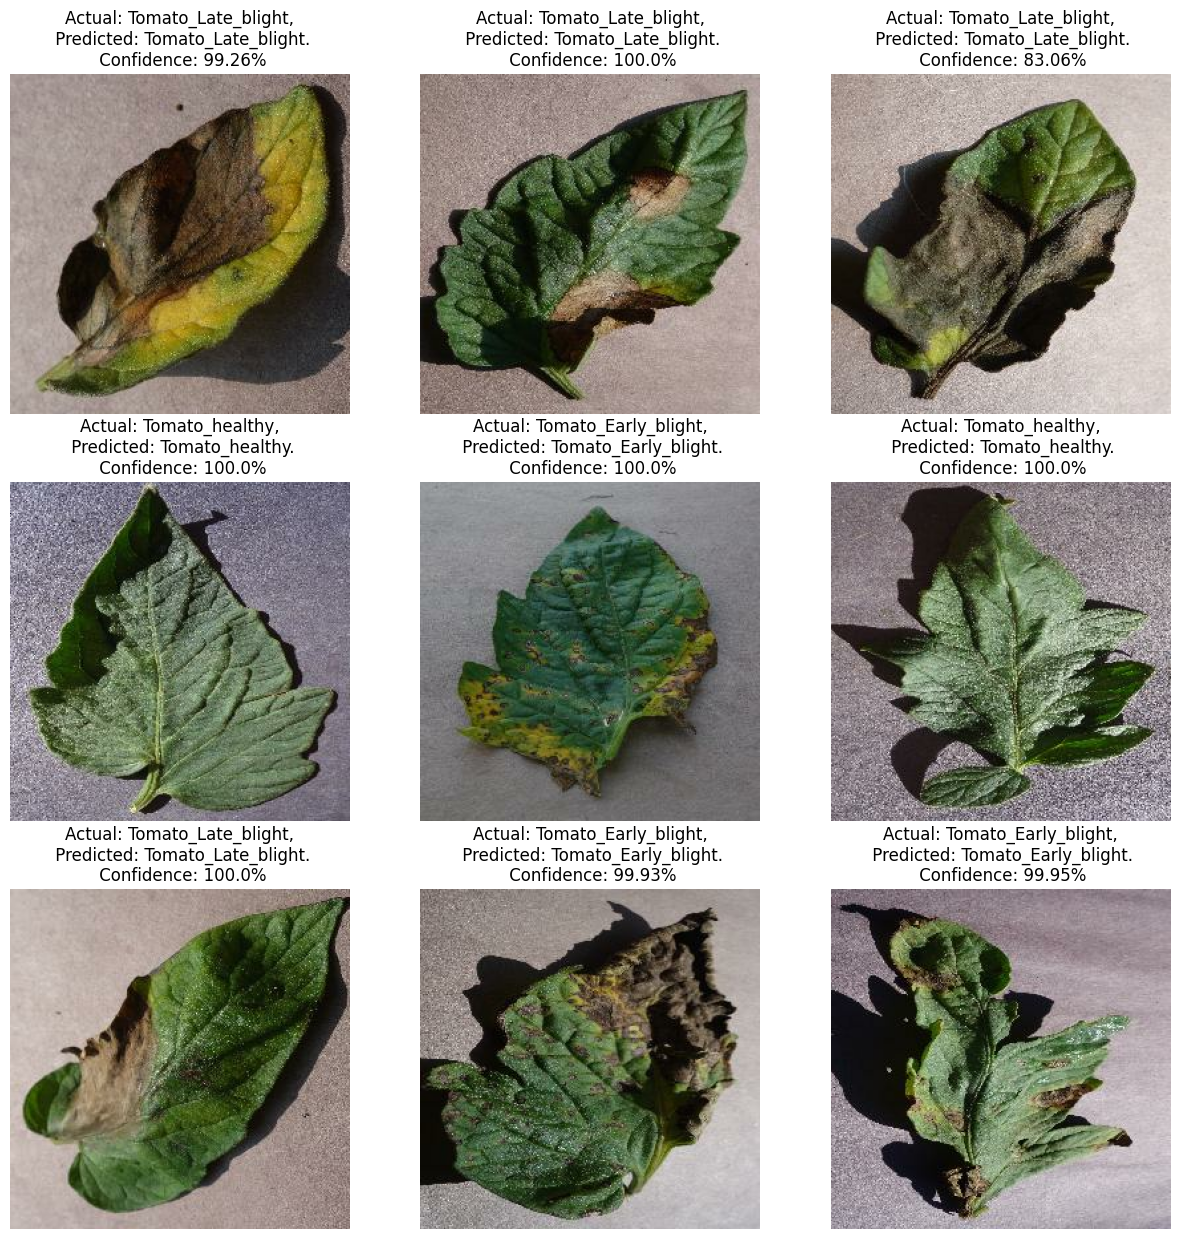

In [55]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        prediction_class, confidance = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {prediction_class}.\n Confidence: { confidance}%")
        plt.axis('off')